# Практическое задание

Черепанов Ярослав, 194

### Задача Bike Sharing

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 9 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

### Анализ и визуализация данных

In [1]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

import seaborn as sns

C:\Installed\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('bike_sharing_train.csv')

In [4]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,1


In [5]:
from datetime import datetime
data.loc[:,'datetime'] = data.datetime.map(lambda date_: datetime.strptime(date_, '%Y-%m-%d %H:%M:%S'))
data.loc[:,'year'] = data.datetime.map(lambda x: x.year) - 2000
data.loc[:,'month'] = data.datetime.map(lambda x: x.month)
data.loc[:,'day'] = data.datetime.map(lambda x: x.day)
data.loc[:,'hour'] = data.datetime.map(lambda x: x.hour)

3 . Проанализируйте описание данных:

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***count*** - number of total rentals

Они все кажутся довольно значимыми, но больше всего будет влиять погода и температура, наверное.

windspeed и humidity

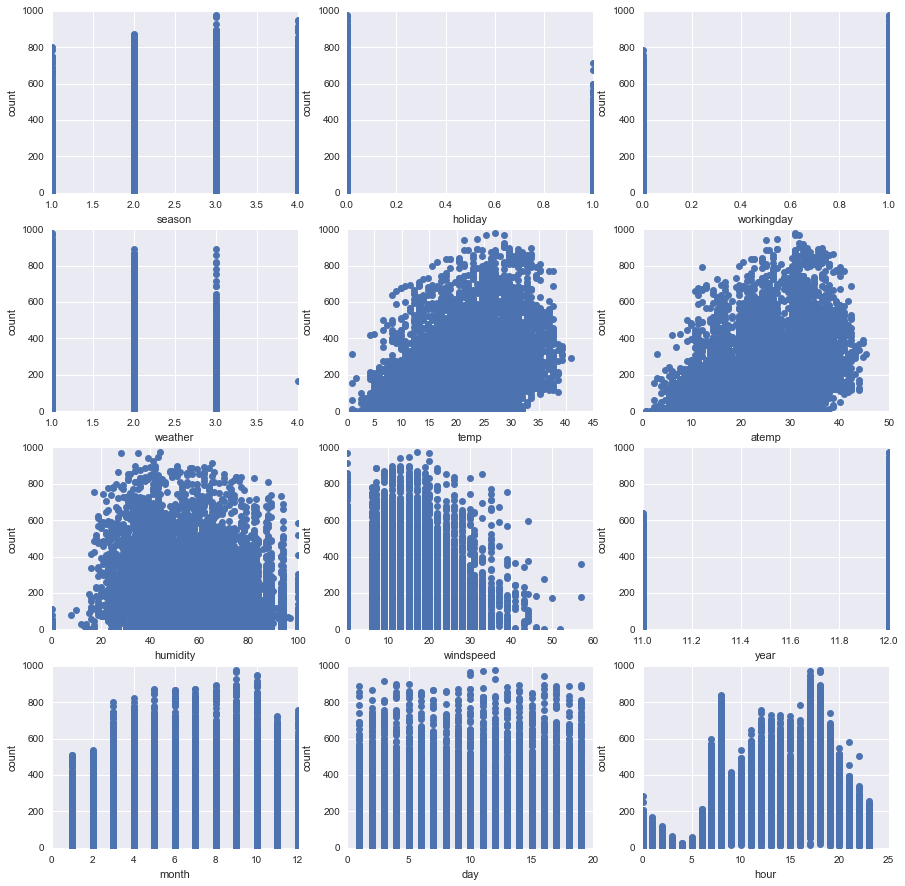

In [6]:
features = data.columns.drop(['count', 'datetime'])
from matplotlib import pylab as plt
fig = plt.figure(figsize=(15,15))
for i in range(len(features)):
    plt.subplot(4, 3, i + 1,)
    plt.xlabel(features[i])
    plt.ylabel('count')
    plt.plot(data[features[i]], data['count'],'o')

Явной корелляции нигде не видно. Видно только что облако точек в температуре более менее походит на вытянутое. В 2012 прокат пользовался большим спросом. Также судя по графикам прокат больше пользуется спросом в рабочие дни (это может быть вызвано элементарно тем, что рабочих дней в выборке больше)

In [7]:
data[features].corrwith(data['count'])

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
year          0.260403
month         0.166862
day           0.019826
hour          0.400601
dtype: float64

Сильно кореллирующих признаков нет, но просто кореллирующими можно назвать к примеру hour, temp и atemp

In [8]:
data[features].corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,-0.004797,0.971524,0.001729,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.012021,0.001731,-0.015877,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.002482,-0.003394,0.009829,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.012548,0.012144,-0.007890,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.061226,0.257589,0.015551,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.058540,0.264173,0.011866,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.078606,0.204537,-0.011335,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,-0.015221,-0.150192,0.036157,0.146631
year,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,1.000000,-0.004932,0.001800,-0.004234
month,0.971524,0.001731,-0.003394,0.012144,0.257589,0.264173,0.204537,-0.150192,-0.004932,1.000000,0.001974,-0.006818


Да, к примеру, сезон неплохо кореллирует с температурой, рабочие дни кореллируют с праздниками. Ну и сезон практически полностью совпадает с месяцем.

In [9]:
data[features].describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,11.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,11.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,11.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,12.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,12.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,12.000000,12.000000,19.000000,23.000000


Масштаб отличается, привести это может к примеру к тому что коэффициенты в модели могут различаться на порядки при неотмасштабированных признаках, хотя они могут вносить одинаковый вклад, что затрудняет интерпретацию модели. К тому же на отмасштабированных признаках градиентный спуск может сходиться быстрее.

### Линейные модели

In [10]:
y_train = data['count'][:int(data.shape[0]*.75)]
y_test = data['count'][int(data.shape[0]*.75):]
X_train = data[features][:int(data.shape[0]*.75)]
X_test = data[features][int(data.shape[0]*.75):]

In [11]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [12]:
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.metrics import mean_absolute_error as MAE

sgd_model = SGDRegressor().fit(X_train, y_train)

lasso_model = Lasso().fit(X_train, y_train)

y_sgd = sgd_model.predict(X_test)
y_lasso = lasso_model.predict(X_test)

print MAE(y_train, sgd_model.predict(X_train))
print MAE(y_train, lasso_model.predict(X_train))

print MAE(y_test, y_sgd)
print MAE(y_test, y_lasso)

93.1626910927
93.7598229612
142.613302538
140.574295413


In [13]:
zip(features, sgd_model.coef_)

[('season', 2.8806522485963395),
 ('holiday', -5.2245313646155749),
 ('workingday', -5.0719977793856517),
 ('weather', -2.5133947249024051),
 ('temp', 19.718556005314362),
 ('atemp', 33.579163636793908),
 ('humidity', -28.642502690297768),
 ('windspeed', 4.322131961074156),
 ('year', 39.585268737294413),
 ('month', 18.352476338177528),
 ('day', -0.89093760467827898),
 ('hour', 42.910456392569493)]

In [14]:
zip(features, lasso_model.coef_)

[('season', 0.0),
 ('holiday', -0.821499691995074),
 ('workingday', -1.1393851806867661),
 ('weather', -5.1569755432627753),
 ('temp', 0.0),
 ('atemp', 53.758802321967451),
 ('humidity', -31.467391253505113),
 ('windspeed', 3.4549365442574209),
 ('year', 40.070327425154204),
 ('month', 20.537966516645877),
 ('day', 0.0),
 ('hour', 46.177219456769507)]

Можно увидеть, что большое влияние имеют температура, влажность, время суток (час) и год

In [15]:
# добавим признак дня недели и бинаризуем час
data.loc[:,'weekday'] = data.datetime.map(lambda x: x.weekday())
data = pd.get_dummies(data, columns=['hour'])
features = data.columns.drop(['datetime', 'count'])

In [16]:
y_train = data['count'][:int(data.shape[0]*.75)]
y_test = data['count'][int(data.shape[0]*.75):]
X_train = data[features][:int(data.shape[0]*.75)]
X_test = data[features][int(data.shape[0]*.75):]

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [17]:
sgd_model = SGDRegressor().fit(X_train, y_train)

lasso_model = Lasso().fit(X_train, y_train)

y_sgd = sgd_model.predict(X_test)
y_lasso = lasso_model.predict(X_test)

print MAE(y_train, sgd_model.predict(X_train))
print MAE(y_train, lasso_model.predict(X_train))

print MAE(y_test, y_sgd)
print MAE(y_test, y_lasso)

67.7476365604
66.3780717407
115.177036327
116.131067349


In [18]:
zip(features, sgd_model.coef_)

[('season', 3.7085643911043178),
 ('holiday', 0.20208051178883296),
 ('workingday', 0.49175200276490821),
 ('weather', -18.052310256568493),
 ('temp', 15.867863199937235),
 ('atemp', 32.900888368863484),
 ('humidity', -13.198480326676576),
 ('windspeed', -4.0431598462661871),
 ('year', 43.865816388323445),
 ('month', 17.985056796475469),
 ('day', 0.7820218383533567),
 ('weekday', 3.1586019823085882),
 ('hour_0', -22.870227936013158),
 ('hour_1', -27.032991997095422),
 ('hour_2', -26.766599325129413),
 ('hour_3', -27.538330256280794),
 ('hour_4', -26.944498697624532),
 ('hour_5', -26.028395637418491),
 ('hour_6', -17.044341775857145),
 ('hour_7', 7.4097342656631771),
 ('hour_8', 30.33755854882639),
 ('hour_9', 7.6384033780822476),
 ('hour_10', -4.1466390328781735),
 ('hour_11', 2.1247454051316983),
 ('hour_12', 10.392563054786654),
 ('hour_13', 10.383605665088975),
 ('hour_14', 5.8213872561233702),
 ('hour_15', 7.3061608932672515),
 ('hour_16', 17.267909137658616),
 ('hour_17', 44.88223

In [19]:
zip(features, lasso_model.coef_)

[('season', 0.0),
 ('holiday', -0.0),
 ('workingday', -0.0),
 ('weather', -15.034355708320049),
 ('temp', 0.0),
 ('atemp', 46.182306891610381),
 ('humidity', -11.930015250031509),
 ('windspeed', -1.7330182660155695),
 ('year', 42.424380530715403),
 ('month', 19.815431242528856),
 ('day', 0.60822449910188403),
 ('weekday', 2.1534429673771105),
 ('hour_0', -25.335037038094942),
 ('hour_1', -27.995180994178597),
 ('hour_2', -29.417570543986056),
 ('hour_3', -30.893815562953822),
 ('hour_4', -31.330393929287645),
 ('hour_5', -28.865001521292346),
 ('hour_6', -18.700589718305661),
 ('hour_7', 2.5744740108215263),
 ('hour_8', 28.205982569209738),
 ('hour_9', 2.5878075418344775),
 ('hour_10', -5.5948766534463372),
 ('hour_11', -1.0305793871074738),
 ('hour_12', 3.8610459573145426),
 ('hour_13', 3.0502102876095942),
 ('hour_14', 0.0),
 ('hour_15', 1.2364929038835344),
 ('hour_16', 11.975606333688033),
 ('hour_17', 40.05335035600276),
 ('hour_18', 34.262829100073105),
 ('hour_19', 14.6414882273

Наш совсем новый признак не особо помог, судя по всему, зато бинаризация сильно повлияла на качество

In [20]:
data = pd.read_csv('bike_sharing_train.csv')
data.loc[:,'datetime'] = data.datetime.map(lambda date_: datetime.strptime(date_, '%Y-%m-%d %H:%M:%S'))
data.loc[:,'year'] = data.datetime.map(lambda x: x.year) - 2000
data.loc[:,'month'] = data.datetime.map(lambda x: x.month)
data.loc[:,'day'] = data.datetime.map(lambda x: x.day)
data.loc[:,'hour'] = data.datetime.map(lambda x: x.hour)
data.loc[:,'weekday'] = data.datetime.map(lambda x: x.weekday())
features = data.columns.drop(['datetime', 'count'])

y_train = data['count'][:int(data.shape[0]*.75)]
y_test = data['count'][int(data.shape[0]*.75):]
X_train = data[features][:int(data.shape[0]*.75)]
X_test = data[features][int(data.shape[0]*.75):]

In [21]:
# Пример:
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте
train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test

# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
MAE(test_labels, estimator.predict(test_data))

153.82024067181084

In [22]:
# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для категориальных признаков
categorical_data_columns = ['year', 'month', 'day', 'hour', 'season', 'weather', 'weekday']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
                            ]))
    

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
MAE(test_labels, estimator.predict(test_data))

112.4119258478608

Положительно. Но примерно такое же качество давала простая бинаризация на фичу hour

In [23]:
parameters_grid = { 
    'model_fitting__loss' : ['huber',  'epsilon_insensitive', 'squared_loss'],
    'model_fitting__n_iter' :[5, 10, 50, 100],
    'model_fitting__penalty' : ['l1', 'l2', 'none'],
    'model_fitting__alpha' : [0.0001, 0.01, 0.001]
}

In [24]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring='mean_absolute_error', cv=5)
grid_cv.fit(train_data, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000CE42128>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...r=5, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__penalty': ['l1', 'l2', 'none'], 'model_fitting__n_iter': [5, 10, 50, 100], 'model_fitting__alpha': [0.0001, 0.01, 0.001], 'model_fitting__loss': ['huber', 'epsilon_insensitive', 'squared_loss']},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [25]:
print grid_cv.best_score_
print grid_cv.best_params_

-72.426089491
{'model_fitting__penalty': 'l2', 'model_fitting__alpha': 0.001, 'model_fitting__n_iter': 50, 'model_fitting__loss': 'squared_loss'}


Сильно положительно

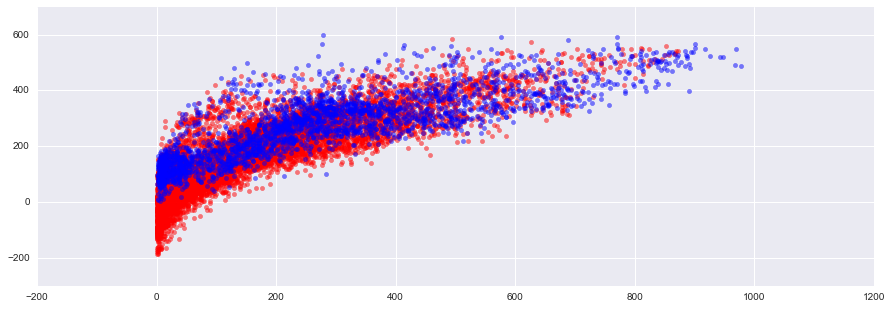

In [26]:
pylab.figure(figsize=(15,5))
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color= 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color= 'blue')

В идеале мы должны получить функцию y=x. Сейчас видно что то только с меньшим наклоном

### Случайный лес

In [27]:
model = ensemble.RandomForestRegressor()

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
                            ]))
    

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
MAE(test_labels, estimator.predict(test_data))

77.154775900073474

In [28]:
importances =  model.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range (train_data.shape[1]):
    print (" feature %d (%f)" % (indices[f], importances[indices[f]]))

 feature 3 (0.187245)
 feature 64 (0.088175)
 feature 1 (0.082651)
 feature 65 (0.079469)
 feature 4 (0.077393)
 feature 55 (0.056821)
 feature 14 (0.046531)
 feature 2 (0.043119)
 feature 15 (0.035685)
 feature 66 (0.028100)
 feature 5 (0.016171)
 feature 54 (0.015057)
 feature 49 (0.014529)


Суда по тому в какой последовательности признаки подавались в pipeline, самым значимым признаком является temp, также значимым является holiday

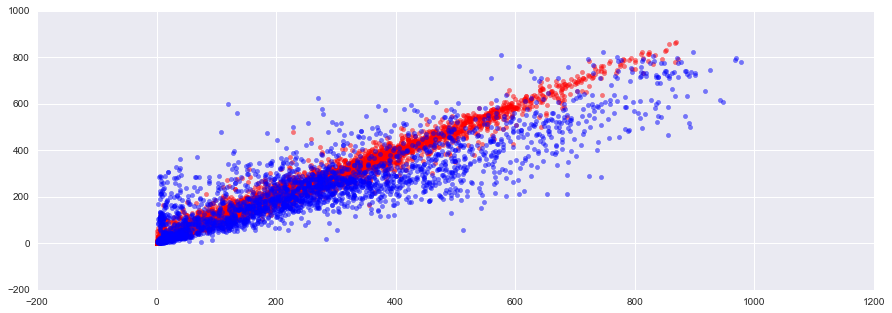

In [29]:
pylab.figure(figsize=(15,5))
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color= 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color= 'blue')

Этот график выглядит намного удачнее.

### Опциональная часть

Попробуйте улучшить результат, полученный на предыдущих шагах. В этом разделе можно и нужно пользоваться любыми изученными алгоритмами, инструментами и всем, чем вам захочется.

### Заключение

В этом разделе Вы можете написать, какие выводы Вы сделали в процессе работы над заданием, понравилось ли оно Вам, а также всё, что Вы о задании думаете =)